In [139]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [140]:
from stompy import utils
import six
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
import os

In [141]:
six.moves.reload_module(dwaq)

<module 'stompy.model.delft.waq_scenario' from '/richmondvol1/rusty/stompy/stompy/model/delft/waq_scenario.py'>

In [142]:
if 1:
    dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_with_temp"
    dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom_with_temp")
    hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom_with_temp.hyd"))
if 0:
    # non-temperature run gets us 2 more days of output. actually no. valid data stops
    # 8/21 23:00,while the temperature runs goes to 8/23 00:00
    dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom"
    dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom")
    hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom.hyd"))

In [143]:
# wholesale copypasta https://github.com/rustychris/agg_wy2013/blob/master/tracer_tests/tracer_common.py
import logging
log = logging.getLogger()

import re
import matplotlib.pyplot as plt
from matplotlib import colors
from shapely import geometry, wkt
import stompy.plot.cmap as scmap
import xarray as xr
from stompy.grid import unstructured_grid
import numpy as np
import pandas as pd
import stompy.model.delft.waq_scenario as dwaq
from stompy.memoize import memoize
import logging as log
from stompy import utils
from stompy import filters
from stompy.plot import plot_wkb
import netCDF4
import warnings
from stompy.model.data_comparison import calc_metrics
import os
import six
from matplotlib import gridspec

cmap=scmap.load_gradient('turbo.cpt') # a less offensive 'jet'

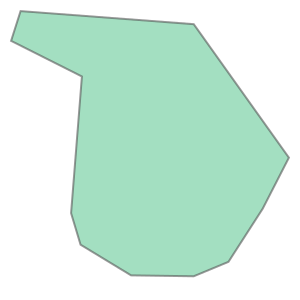

In [144]:
# Regions (copy paste from QGIS vector layer)
oakland_wkt="""Polygon ((560434.67213132162578404 4183884.9798020776361227, 
567612.90416294464375824 4183342.8737371894530952, 571557.19311782089062035 
4177809.65321281319484115, 570472.98098804452456534 4175697.30889100721105933, 
569052.2892317856894806 4173491.49800628982484341, 567612.90416294464375824 
4172893.3120036544278264, 565014.53371399780735373 4172930.69862881954759359, 
562920.88270477438345551 4174201.84388441918417811, 562528.32314054504968226 
4175510.37576518394052982, 562976.96264252148102969 4181174.44947763625532389,
560042.11256709217559546 4182651.2211716421879828, 560434.67213132162578404 
4183884.9798020776361227))
"""
oakland_poly=wkt.loads(oakland_wkt)
oakland_poly

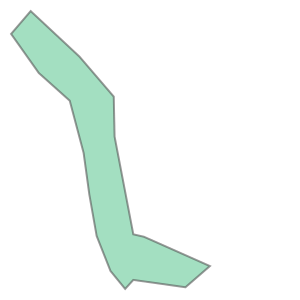

In [145]:
eastshore_wkt="""Polygon ((568776.56287119572516531 4174108.37732150498777628,
570122.4813771250192076 4175678.61557842278853059, 573487.2776419484289363
4172538.13906458765268326, 575842.63502732466440648 4169790.22211498161777854, 
575898.71496507176198065 4167042.30516537604853511, 577188.55353325395844877 
4160312.71263572946190834, 577917.59272396576125175 4160144.47282248828560114, 
582460.06768147717230022 4158125.59506359416991472, 580777.66954906552564353 
4156667.51668217079713941, 577188.55353325395844877 4157172.23612189432606101, 
576627.75415578344836831 4156555.3568066768348217, 575618.31527633650694042 
4157789.11543711181730032, 574664.95633463654667139 4160200.55276023549959064, 
574160.23689491301774979 4163060.62958533503115177, 573767.67733068368397653 
4165920.7064104350283742, 572814.3183889837237075 4169509.82242624647915363, 
570683.28075459564570338 4171416.54030964663252234, 568776.56287119572516531 
4174108.37732150498777628))
"""
eastshore_poly=wkt.loads(eastshore_wkt)
eastshore_poly

In [149]:
def hydro_name(hydro): return "wy2022_bloom"

def configure_dwaq(): # May be outdated, esp. for chicago.
    # configure DWAQ:
    DELFT_SRC="/opt/software/delft/delwaq/precompiled_binaries/DFM1.6.2.49199/lnx64"
    #DELFT_SRC="/home/alliek/software/Delft3D-FM/64634"
    DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
    DELFT_LIB=os.path.join(DELFT_SRC,"lib")

    os.environ['DELFT_SRC']=DELFT_SRC
    os.environ['DELFT_SHARE']=DELFT_SHARE
    
    if 'LD_LIBRARY_PATH' in os.environ:
        os.environ['LD_LIBRARY_PATH']=DELFT_LIB+":"+os.environ['LD_LIBRARY_PATH']
    else:
        os.environ['LD_LIBRARY_PATH']=DELFT_LIB

configure_dwaq()

class CommonSetup(object):
    """
    Common code for various tracers runs
    """
    name='common' # should overload
    hydro=None
    base_path=None # must be set!

    force=True # whether to allow re-using an existing run
    
    # start time offset from start of hydro by this delta
    # give it some decent spinup time
    start_time=np.datetime64("2022-08-10 00:00")
    
    # set length of the run. Appears to be the end of valid output, even though the
    # hydro reports going until the 25th.
    stop_time=np.datetime64("2022-08-22 23:00") # seems that even temperature run is dicey on last step
    
    integration_option="15.60" # if set, copied to WaqModel
    time_step=3000
    map_time_step=3000 # otherwise it will default to time_step, which could be really short.    

    def __init__(self,**kw):
        utils.set_keywords(self,kw)   
        if self.base_path is None:
            self.base_path=self.calc_base_path()
                
            yyyymmdd=utils.to_datetime(self.start_time).strftime('%Y%m%d')
            self.base_path+="_%s"%(yyyymmdd)   
            
            # And make it unique on successive runs
            for seq in range(50):
                test_path=self.base_path
                if seq>0:
                    test_path+=f"-v{seq:03}"
                if not os.path.exists(test_path):
                    self.base_path=test_path
                    break
            else:
                raise Exception("Too many runs with same name")
            
            log.info("base_path defaults to %s"%self.base_path)
    def calc_base_path(self):
        p='run_%s_%s'%(hydro_name(self.hydro),self.name)
        return p
        
    def release_conc_3d(self,*a,**kw):
        C_2d=self.release_conc_2d(*a,**kw)
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def setup_model(self):
        # Create a WaqModel, add some tracers
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path,
                                 mon_time_step=1000000, # daily
                                 time_step=self.time_step)
        # add some option for balances.
        wm.integration_option="%s BALANCES-OLD-STYLE BAL_NOLUMPPROCESSES BAL_NOLUMPLOADS BAL_NOLUMPTRANSPORT"%self.integration_option
        #wm.start_time+= self.start_offset
        wm.start_time = self.start_time # may have to be smarter about starting on an output time step.
        # hydro reports the wrong stop time. manually set.
        if self.stop_time is not None:
            wm.stop_time=self.stop_time
        
        self.setup_tracers()
        
        wm.parameters['ACTIVE_VertDisp']=1
        wm.parameters['ScaleVDisp']=1.0 
        
    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path,load_hydro=False)
                return

        self.setup_model()
        
        wm=self.wm
        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.cmd_write_nc()
    
    def setup_tracer_continuity(self):
        # continuity tracer:
        self.wm.substances['continuity']=dwaq.Substance(initial=1.0)
        # This adds a concentration=1.0 boundary condition on all the boundaries.
        all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]
        self.wm.add_bc(all_bcs,'continuity',1.0)
    
        
class Blobber(CommonSetup):
    # plume parameters
    X0=np.array([564560,4.17838e6])
    L=2000
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    name='gaussian' # used to form default base_path
    
    def release_conc_2d(self,X0,L):
        grid=self.hydro.grid()
        X=grid.cells_centroid()
        
        c=np.exp( -((X-X0)**2).sum(axis=-1)/L**2 )
        c=c/c.max() # make max value 1
        return c

    def setup_tracers(self):
        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d(X0=self.X0,L=self.L)
        self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)
        self.setup_tracer_continuity()
    
class PolyBlobber(CommonSetup):
    """
    Seed with regional dye releases
    """
    # plume parameters
    release_polys=[(oakland_poly,'oakland'),
                   #(eastshore_poly,'eastshore')
                  ]
    
    def release_conc_2d(self,poly):
        grid=self.hydro.grid()
        # This could also be used to sample from satellite data.
        c=grid.select_cells_intersecting(poly,by_center='centroid')
        c=c.astype(np.float64)
        return c
        
    def setup_tracers(self):
        for poly,name in self.release_polys:
            # boundary condition will default to 0.0
            C_3d=self.release_conc_3d(poly=poly)
            self.wm.substances[name]=dwaq.Substance(initial=C_3d)
                    
    # Plotting is old -- not yet updated for this application.
    def figure_2panels_and_time(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        his_ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_hist.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)
        
        fig=plt.figure(self.fig_num)
        gs=gridspec.GridSpec(1,4)
        
        axs=[fig.add_subplot(gs[:,0]),
             fig.add_subplot(gs[:,1])]
        ax_t=fig.add_subplot(gs[:,2:])
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)
        
        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=self.cmap,
                                   clim=[0,1])
        # at the end
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=self.cmap,
                                   clim=[0,1])
        
        for coll in [coll_ic,coll_ec]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs[:2]:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)
            
        ax_t.plot(his_ds.time,his_ds.bal.sel(region='region',field='dye1'))
            
        fig_title=self.hydro.hyd_path
                    
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text
                    
        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
        his_ds.close()
        
class SurfaceBlobber(PolyBlobber):
    dz_surface=2.0
    def release_conc_3d(self,*a,**kw):
        C_2d=self.release_conc_2d(*a,**kw)
        C_3d=self.hydro.extrude_element_to_segment(C_2d)

        # And now limit to the surface
        start_t_secs=int( (self.start_time - utils.to_dt64(self.hydro.time0))/np.timedelta64(1,'s'))
        seg_ztop,seg_zbot = self.hydro.seg_z_range(start_t_secs)

        dz=seg_zbot-seg_ztop
        dz_release=(seg_zbot.clip(None,self.dz_surface) - seg_ztop).clip(0,None)
        frac=dz_release/dz
        C_3d *= frac

        return C_3d
    

def recalc_age(cons,decay,rate=0.01,min_cons=1e-7):
    # There are some numerical issues with the age tracers, notably
    # that in some cases the decaying tracer is greater than the
    # conservative tracer.
    # recalculate age to have a better sense of where
    # the nan's are.
    # the rate here is the default in dwaq, with units of day-1
    
    # possible for cons or decay to be nan, 0, or for cons<decay,
    # all of which are problematic.
    with np.errstate(invalid='ignore',divide='ignore'):
        valid=(cons>1e-7)
        my_age=np.log(decay/cons) / np.log(1-rate)
        my_age[ cons<min_cons]=np.nan
        my_age[ decay>cons]=0.0
        my_age[np.isnan(cons*decay)]=np.nan 
    return my_age

# have not adapted Decaying tracer to bloom scenario yet.
class DecayingPlume(CommonSetup):
    """
    A continuous source of decaying tracer.
    """
    name='tripleDecay' 
            
    # source parameters
    X0=np.array([ # [567500,4.16795e6], # middle of S Bay
                  [571931,4165989], # S Bay E shoal, just north of SMB
                  [560611,4165243], # S Bay channel, off SFO
                  [581860,4148149]  # LSB, near CM17
     ])
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    decay_rate=0.01 # for WAQ decay process 
    
    tracer_clim=[0,0.5]
    age_clim=[0,60]

    def calc_base_path(self):
        b=super(DecayingPlume,self).calc_base_path()
        if self.decay_rate!=0.01: # the default
            b+="_decay%g"%self.decay_rate
        return b
    
    def setup_tracers(self):
        # boundary condition will default to 0.0
        for i,x0 in enumerate(self.X0):
            ctr="cTr%d"%(1+i)
            dtr="dTr%d"%(1+i)
            proc="ACTIVE_Age%d"%(1+i)
            self.wm.parameters['RcDecTR%d'%(1+i)]=self.decay_rate
            
            self.wm.substances[ctr]=dwaq.Substance(initial=0.0)
            self.wm.substances[dtr]=dwaq.Substance(initial=0.0)
            elt=self.hydro.grid().select_cells_nearest(x0)
            discharge=self.wm.add_discharge(element=elt,k=0)
            self.wm.add_load([discharge],[ctr,dtr],100.0)
            # Somehow, DWAQ is coming up with dTr1 values greater than cTr1
            # in some cases.  Maybe related to the integration scheme.
            # Even though I don't use the Age output, I'm keeping the process
            # on as a way to make sure that decay is turned on.  It should be
            # possible to directly turn decay on, and not calculate age.
            # no big difference...
            self.wm.parameters[proc]=1
            # I think it's actually possible to have 5, but only 3 age
            # tracers. And there are probably some other decaying processes
            # that could be co-opted if necessary.
            assert i<5,"Only 5 decay tracers allowed"
        # I'm going to recalculate my own age, so no need to output it.
        #self.wm.map_output = self.wm.map_output + ('AgeTr1',)




In [150]:
#pb=PolyBlobber(hydro=hydro)
pb=SurfaceBlobber(hydro=hydro)

INFO:root:base_path defaults to run_wy2022_bloom_common_20220810-v003


In [151]:
pb.run_waq_model()

INFO:WaqModel: start time updated from hydro: 2022-05-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2022-08-23T00:00:00.000000
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7f0ef4cb3a60>), ('bottomdept', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7f0f75a0eeb0>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f0f3a8e1940>), ('tau', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f0f3a8e1610>), ('temp', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f0f3a8e18b0>), ('salinity', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7f0f3a8e1c70>)])
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey boundary-links.csv
INFO:HydroFiles:Writing hyd file
INFO:HydroFiles:Segment depth will be infe

In [90]:
# If the run doesn't fail out, this isn't necessary
pb.wm.cmd_write_nc()

INFO:WaqModel:NEFIS file didn't exist. Skipping ugrid_nef()


In [ ]:
# Looking like a 40 minute run or so with one tracer, one core.
# Make sure the time period is correct -- there are some odd messages in the mon file.
# T0 is 2022-05-01
# But there is a message:
# SIMULATION TIME :  101D  0H  0M  0S !                                                                                                         
# TIME IN FILE    :   15D  6H 19M 34S !                                                                                                         

# What is that about?

# And the run fails early:
# REWIND ON           UNIT:  20, READING: com-waqmodel.vol                                                                                      
# AT SIMULATION TIME:  112D 23H  0M  0S !                                                                                                       
# TIME IN FILE:        112D 23H  0M  0S !

# Maybe the original hydro, or the conversion, failed early?

In [ ]:
# How to run arbitrary processes?
# Would like conc, age-conc, age-depth-conc
# conc00, agec00, agedepthc00
# need a process that will integrate a source term that is the product of 
# two input variables (those being conc00 and localDepth)
# at the same time, will need to integrate just conc00, to get agec00

# Looks like I will need waqpbexport and the original csv process tables at the least
